# AR(1) process with unknown parameters

An AR(1) process is a stochastic process that satisfies the following equation:
$$
  X_t = \rho X_{t-1} + \epsilon_t,
$$
where $\rho$ is a parameter between -1 and 1 and $\epsilon_t \sim N(0, \sigma^2)$ is a noise term.

Let's assign a prior to $\rho$ and $\sigma^2$ as follows:
$$
  \rho \sim \text{Uniform}(-1, 1),
  \quad \text{and} \quad
  \sigma^2 \sim \text{Uniform}(0, A),
$$
where $A > 0$.

## Sampling from the prior and likelihood

We can generate from this prior distribution over the parameter $\boldsymbol{\theta} = (\rho, \sigma)$:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

A = 5
rho_sample = np.random.uniform(-1, 1)
sigma_sample = np.random.uniform(0, A)

print(rho_sample, sigma_sample)

-0.7661078664389753 2.698302603704541


We can draw $K$ samples using numpy as follows:

In [3]:
K = 4
rho_batch_example = np.random.uniform(-1, 1, size=K)
sigma_batch_example = np.random.uniform(0, A, size=K)

print(rho_batch_example, sigma_batch_example)

[0.41082293 0.24104424 0.91238382 0.29374079] [0.66238679 3.78264625 1.79051412 2.9864584 ]


Conditioned on $\rho$ and $\sigma$, we can generate a time series of length $N$, $\mathbf{x} = (x_1, x_2, \ldots, x_N)$ from the AR(1) process as follows:

In [5]:
N = 64
# Note: this is the marginal distribution of the process, we use it to initialise the series
x_prev = np.random.normal(0, sigma_sample ** 2 / (1 - rho_sample ** 2))
x = np.zeros(N)
for i in range(N):
    x[i] = rho_sample * x_prev + np.random.normal(0, sigma_sample)
    x_prev = x[i]

print(x)


[-5.82309720e+00  4.33333263e+00 -7.94044637e+00  9.93170995e+00
 -9.61549489e+00  7.79164511e+00 -3.98451087e+00 -2.12733179e+00
  2.28931069e+00 -1.88784918e+00  3.96533830e-03  2.16316469e+00
 -1.17041456e+00  5.02592145e-02 -3.06765733e+00  4.39752835e+00
 -4.98200289e+00  6.42663333e-01  4.15462370e+00 -2.56939967e+00
  3.20204908e+00 -8.09580091e+00  6.20666578e+00  6.35571190e-01
  2.13853342e+00  1.84683557e+00  2.89745139e+00 -5.58908404e+00
  2.99260316e+00 -6.45919958e+00  6.49481004e+00 -6.44536451e+00
  1.15221908e+00 -5.01066751e-02  1.24100307e+00 -1.39085341e+00
  1.11307165e+00 -4.60499041e+00  2.72528106e+00 -6.91420472e+00
  5.06352079e+00 -9.19459162e+00  8.51013141e+00 -3.08009291e+00
 -2.63328160e+00  3.16168984e+00 -1.13142162e-01  2.11541868e+00
  4.25748806e+00 -3.62897687e+00  3.85380019e+00  4.12479898e-01
  4.50333501e+00 -4.08826320e+00 -2.14245243e+00  4.84955195e-01
  1.06208702e+00 -3.42424833e+00  4.23165334e+00 -3.34890667e+00
  1.43704035e+00 -2.66194

We can plot the time series as follows:

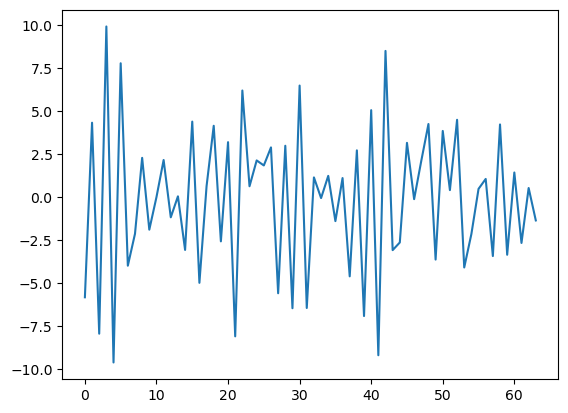

In [6]:
plt.plot(x)
plt.show()

For a batch of $K$ values of $\sigma_k$, $k = 1, 2, \ldots, K$, we can generate $K$ batches of $\mathbf{x}_k$, where each batch has parameters $\rho_k$ and $\sigma_k$ as follows:

In [11]:
rho_batch_wide = rho_batch_example.reshape(-1, 1)
sigma_batch_wide = sigma_batch_example.reshape(-1, 1)
x_prev_batch = np.random.normal(0, sigma_batch_wide ** 2 / (1 - rho_batch_wide ** 2), size=(K, N))
x_batch_example = np.zeros((K, N))
for i in range(N):
    x_batch_example[:, i] = rho_batch_example * x_prev_batch[:, i] + np.random.normal(0, sigma_batch_example)
    x_prev_batch[:, i] = x_batch_example[:, i]

print(x_batch_example.shape)

(4, 64)


We can plot the time series from each batch together:

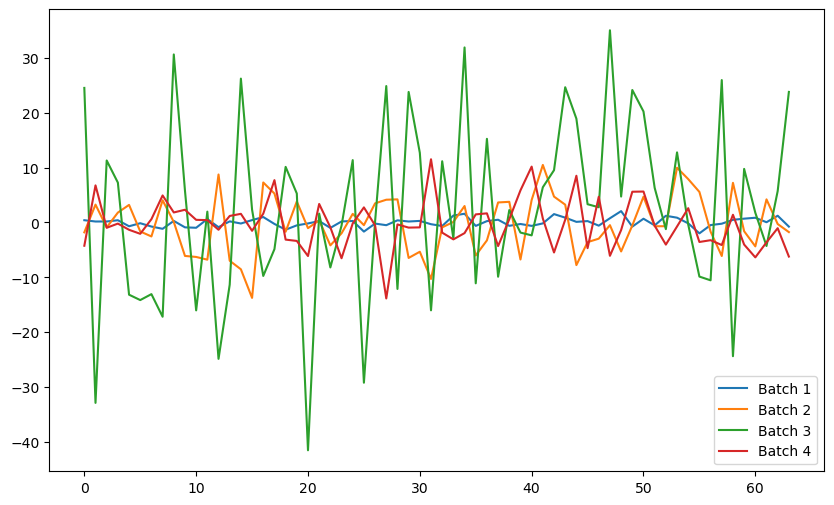

In [12]:
plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(x_batch_example[k], label=f'Batch {k+1}')
plt.legend()
plt.show()

## Sampling from the posterior with Stan

**Exercise:** Use Stan to sample from the posterior distribution of $\rho$ and $\sigma^2$ given the data $\mathbf{x}$. If you get stuck, you should be able to find examples online.

## Neural network inference

**Exercise:** Implement this by generalising the code from previous problems.

The new thing here is that the data are not longer i.i.d., so you don't want a permutation invariant network any more. Instead you can use a convolutional network as the summary network. Here is a starting point, but I haven't tested it for this problem yet!

In [15]:
import torch
from torch import nn
from torch.nn import functional as nnf

class MLP(nn.Module):
  '''
  A simple MLP with two hidden layers.
  '''
  def __init__(self, input_dim, output_dim, hidden_dim):
    super().__init__()
    self.nn = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, output_dim)
    )
    
  def forward(self, x):
    return self.nn(x)
    

class PosteriorMeanEstimator(nn.Module):
    def __init__(
        self,
        summary_stats=32,
        summary_kernel_size=3,
        summary_channels=32,
        estimator_width=32,
        output_dim=1
    ):
        super().__init__()

        # Convnet summary layer
        padding = summary_kernel_size // 2
        self.summary = nn.Sequential(
            nn.Conv1d(1, summary_channels, summary_kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(summary_channels, summary_channels, summary_kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(summary_channels, summary_stats, summary_kernel_size, padding=padding),
        )
        # MLP estimator layer
        self.estimator = MLP(summary_stats, output_dim, hidden_dim=estimator_width)

    def forward(self, x):
        # We add an extra dimension to the input to set the number of input channels to one
        x_summary = self.summary(x.unsqueeze(-2))
        # We sum the summary statistics across all observations, then apply the estimator
        return self.estimator(x_summary.sum(-1))

estimator = PosteriorMeanEstimator(output_dim=2)
x = torch.randn(4, 100)
output = estimator(x)
print(output.shape)

torch.Size([4, 2])


You may need to adjust the number of channels and the kernel size to get a good fit.